Import Needed Libraries

In [35]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense , Conv1D , BatchNormalization , Activation ,Reshape , Dot, GlobalMaxPooling1D , Dropout
from matplotlib import pyplot as plt

In [7]:
tf.random.set_seed(1234)

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available:",len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

GPUs Available: 1


Downlod the Dataset

In [10]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 [==============================] - 7s 0us/step


Visualize a Mesh from the Dataset

In [12]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [17]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

In [18]:
mesh = trimesh.load(os.path.join(DATA_DIR, "desk/train/desk_0002.off"))
mesh.show()

Sample a Mesh and Show

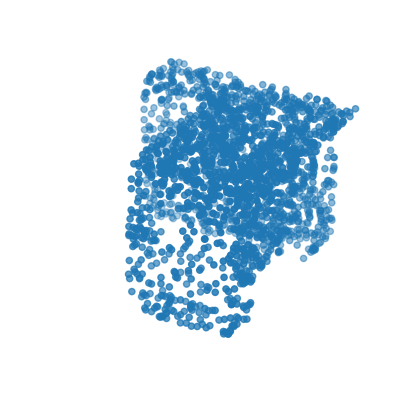

In [19]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

Function to Parse Data



*   Each mesh is loaded and sampled into a point cloud and is returned as a numpy array





In [22]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

Parse the DataSet and Process each Class

In [21]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


processing class: chair
processing class: night_stand
processing class: table
processing class: toilet
processing class: sofa
processing class: bed
processing class: monitor
processing class: dresser
processing class: bathtub
processing class: desk


Augenmentaion for Train DataSet

In [24]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


Building The Deep Model



1.   Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.



In [27]:
def conv_bn(x, filters):
    x = Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = BatchNormalization(momentum=0.0)(x)
    return Activation("relu")(x)


def dense_bn(x, filters):
    x = Dense(filters)(x)
    x = BatchNormalization(momentum=0.0)(x)
    return Activation("relu")(x)

In [28]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


Create the Convolution Neural Network

In [32]:
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return Dot(axes=(2, 1))([inputs, feat_T])

Compile and Train The Model

In [36]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = Dropout(0.3)(x)
x = dense_bn(x, 128)
x = Dropout(0.3)(x)

outputs =Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 2048, 32)             128       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_31 (Ba  (None, 2048, 32)             128       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_31 (Activation)  (None, 2048, 32)             0         ['batch_normalization_3

In [38]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 46s 158ms/step - loss: 3.5010 - sparse_categorical_accuracy: 0.2829 - val_loss: 15003318820219834597376.0000 - val_sparse_categorical_accuracy: 0.3172
Epoch 2/20
125/125 [==============================] - 19s 149ms/step - loss: 3.0071 - sparse_categorical_accuracy: 0.3919 - val_loss: 9234881913552896.0000 - val_sparse_categorical_accuracy: 0.4570
Epoch 3/20
125/125 [==============================] - 19s 150ms/step - loss: 2.6136 - sparse_categorical_accuracy: 0.4836 - val_loss: 1642724608.0000 - val_sparse_categorical_accuracy: 0.4692
Epoch 4/20
125/125 [==============================] - 19s 151ms/step - loss: 2.5026 - sparse_categorical_accuracy: 0.5390 - val_loss: 12210456547302295207936.0000 - val_sparse_categorical_accuracy: 0.5606
Epoch 5/20
125/125 [==============================] - 19s 151ms/step - loss: 2.3784 - sparse_categorical_accuracy: 0.6039 - val_loss: 9499289059328.0000 - val_sparse_categorical_accuracy: 0.6982
Epoch

Visualize The Predictions

1/1 [==============================] - 2s 2s/step


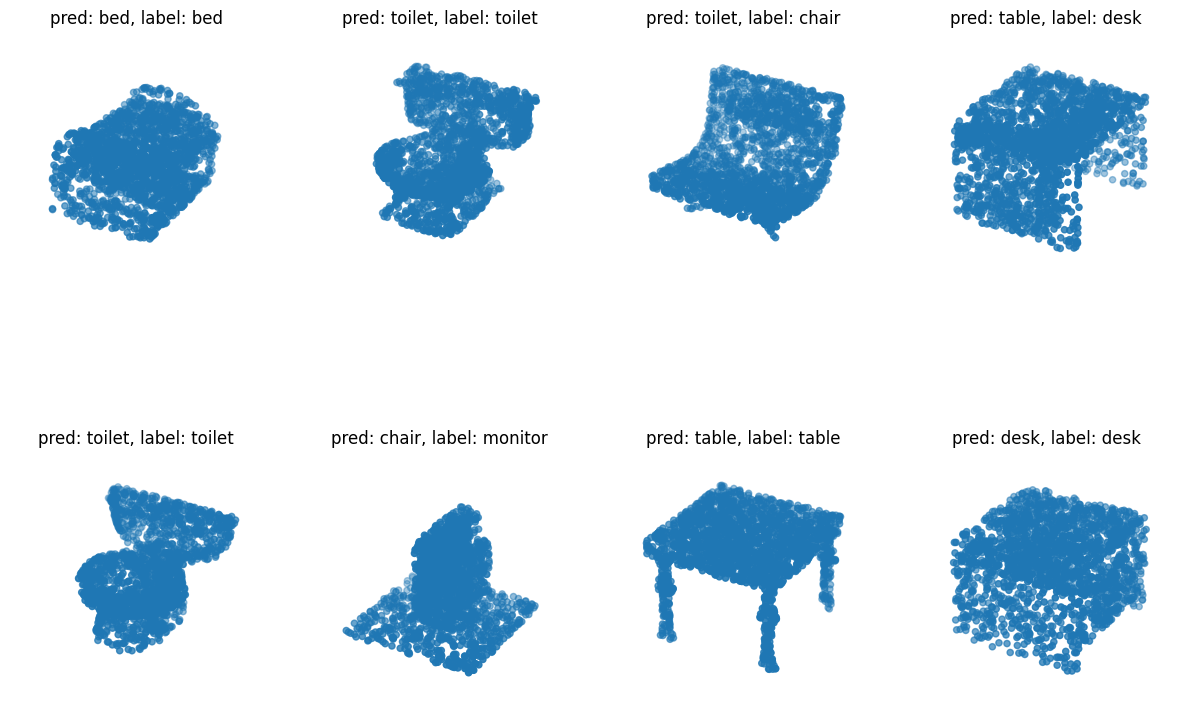

In [39]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()